**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

In [4]:
# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=3, cluster_std=[1.7,1.8,1.6] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(10000, 3) (10000,)


In [6]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

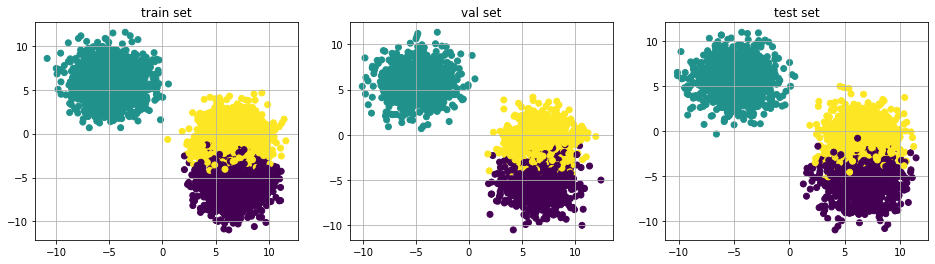

In [7]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [8]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## SLP + MSQE + GD

(4489, 3) (2211, 3) (3300, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


(array([1495., 1501., 1493.]),
 array([766., 738., 707.]),
 array([1073., 1094., 1133.]))

 30%|███       | 6/20 [00:00<00:00, 286.15it/s, loss=0.302, lr=0.1]

NameError: name 'model' is not defined
(3, 3)
[INFO    ] 2021-10-05 20:56:11 | GrowthBreaking: significant increase in the loss function has been detected


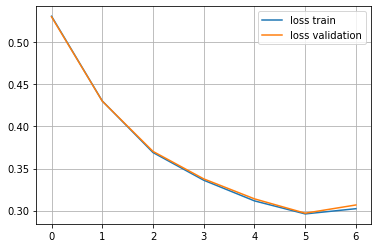

In [9]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

from lib.model.linear import SLP
# from lib.initiator.linear import NormalInitiatorLinearModel
from lib.initiator.linear import UniformInitiatorLinearModel

%xdel model

model = SLP(
    initiator=UniformInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        high=.001,
    )
)

print(model.weight.shape)

from lib.loss.msqe import MSQE
loss_train = MSQE(model)
loss_val = MSQE(model)

from lib.optimizer.gd import GD 
from lib.optimizer.lrate import ConstLRA 
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

lra = ConstLRA(.1)

model = GD( 
    loss=loss_train, 
    loss_val=loss_val, 
    lra=lra,
    breaker_val=[GrowthBreaking(),]
).fit( 
    data_train=[X_train,y_train], 
    data_val=[X_val,y_val], 
    n_epoch=20,
)

from lib.estimator.loss import LossPlot
LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

- - - - - - - - - - - - - - - - - - - - - -
all classes:
predict select argmax scores

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1073
           1       1.00      1.00      1.00      1094
           2       0.87      0.94      0.90      1133

    accuracy                           0.93      3300
   macro avg       0.93      0.93      0.93      3300
weighted avg       0.93      0.93      0.93      3300

- - - - - - - - - - - - - - - - - - - - - -

class 0:
score threshold:0.5794916710582839

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      2227
         1.0       0.92      0.93      0.93      1073

    accuracy                           0.95      3300
   macro avg       0.94      0.95      0.95      3300
weighted avg       0.95      0.95      0.95      3300

- - - - - - - - - - - - - - - - - - - - - -

class 1:
score threshold:0.6474111925193726

              precision  

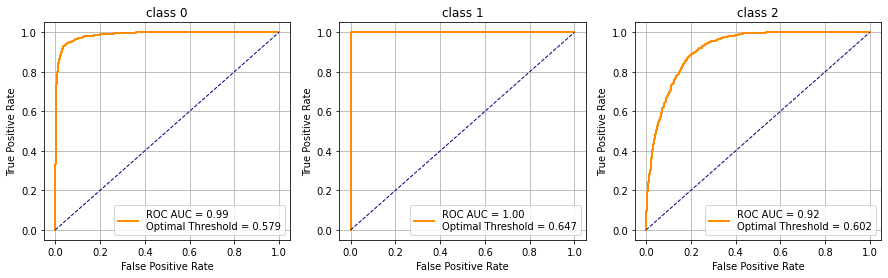

In [10]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## Softmax  + CCE + GD

In [11]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {0,+1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(4489, 3) (2211, 3) (3300, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


(array([1495., 1501., 1493.]),
 array([766., 738., 707.]),
 array([1073., 1094., 1133.]))

  2%|▏         | 2/100 [00:00<00:00, 158.16it/s, loss=1.86, lr=0.01]

(3, 3)
[INFO    ] 2021-10-05 20:56:20 | GrowthBreaking: significant increase in the loss function has been detected


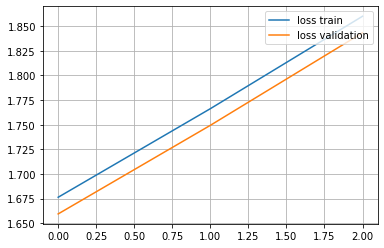

In [12]:
from lib.model.linear import Softmax 
from lib.initiator.linear import NormalInitiatorLinearModel
# from lib.initiator.linear import UniformInitiatorLinearModel

model = Softmax(
    # initiator=UniformInitiatorLinearModel(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        scale=.1,
    )
)

print(model.weight.shape)

from lib.loss.cce import CCE # ф-ция потери - категориальная кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
# from lib.optimizer.breaker import ThresholdBreaking # прерывание по достижению порога значения ф-ции потери
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери
# from lib.optimizer.breaker import DifferenceBreaking # прерывание при отсутствии изменения значения ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
    # breaker=[GrowthBreaking(),ThresholdBreaking(2.),DifferenceBreaking()]
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

- - - - - - - - - - - - - - - - - - - - - -
all classes:
predict select argmax scores

              precision    recall  f1-score   support

           0       0.98      0.18      0.31      1073
           1       0.00      0.00      0.00      1094
           2       0.00      0.00      0.00      1133

    accuracy                           0.06      3300
   macro avg       0.33      0.06      0.10      3300
weighted avg       0.32      0.06      0.10      3300

- - - - - - - - - - - - - - - - - - - - - -

class 0:
score threshold:0.33041309059604357

              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      2227
         1.0       0.86      0.93      0.90      1073

    accuracy                           0.93      3300
   macro avg       0.92      0.93      0.92      3300
weighted avg       0.93      0.93      0.93      3300

- - - - - - - - - - - - - - - - - - - - - -

class 1:
score threshold:0.331275676241757

              precision  

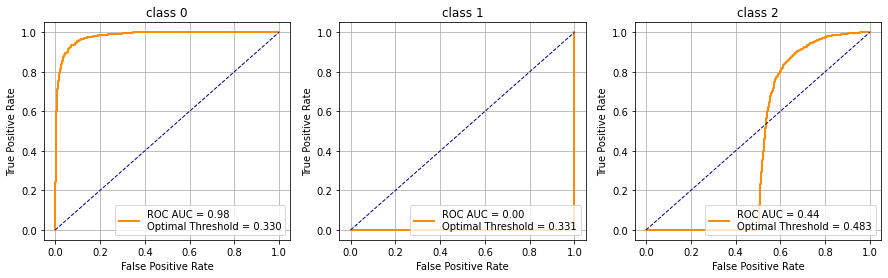

In [13]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## SPL_BPS + LogisticLoss + GD

In [14]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

(4489, 3) (2211, 3) (3300, 3)
[[-1. -1.  1.]
 [-1.  1. -1.]
 [ 1. -1. -1.]]


 42%|████▏     | 42/100 [00:00<00:00, 418.42it/s, loss=1.99, lr=0.01]

weight: (3, 3)


100%|██████████| 100/100 [00:00<00:00, 430.54it/s, loss=1.95, lr=0.01]


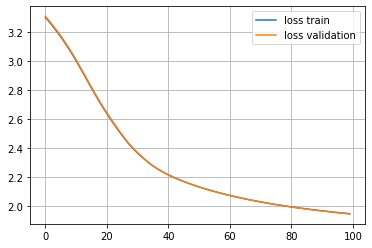

In [15]:
from lib.model.linear import SLP_BPS
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP_BPS(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
    )
)

print('weight:',model.weight.shape)

from lib.loss.logistic import LogisticLoss
loss_train = LogisticLoss(model)
loss_val = LogisticLoss(model)


# from lib.loss.binary.hinge import HingeLoss
# loss_train = HingeLoss(model)
# loss_val = HingeLoss(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
# from lib.optimizer.breaker import ThresholdBreaking # прерывание по достижению порога значения ф-ции потери
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери
# from lib.optimizer.breaker import DifferenceBreaking # прерывание при отсутствии изменения значения ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
    # breaker=[GrowthBreaking(),ThresholdBreaking(2.),DifferenceBreaking()]
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

- - - - - - - - - - - - - - - - - - - - - -
all classes:
predict select argmax scores

              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1073
           1       0.78      1.00      0.88      1094
           2       0.00      0.00      0.00      1133

    accuracy                           0.66      3300
   macro avg       0.45      0.67      0.53      3300
weighted avg       0.44      0.66      0.53      3300

- - - - - - - - - - - - - - - - - - - - - -

class 0:
score threshold:-0.7820943558188185

              precision    recall  f1-score   support

        -1.0       0.89      0.75      0.81      2227
         1.0       0.61      0.80      0.69      1073

    accuracy                           0.77      3300
   macro avg       0.75      0.78      0.75      3300
weighted avg       0.80      0.77      0.77      3300

- - - - - - - - - - - - - - - - - - - - - -

class 1:
score threshold:-0.6543979405964703

              precision

/home/mechanoid/python3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mechanoid/python3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mechanoid/python3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


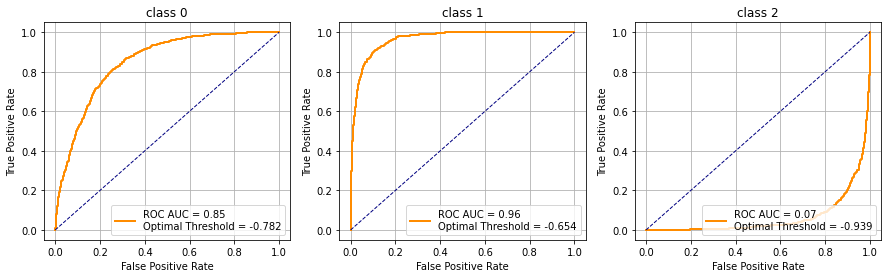

In [16]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)